# Binary Integration

This notebook describes how the Binary Integration workflow is performed, using the pbmc10k dataset as an example.

In [ ]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn.metrics import adjusted_rand_score

In [ ]:
import rpy2
%load_ext rpy2.ipython

In [ ]:
import muon as mu
import muon.atac as ac

/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# set folder to save figures and set a prefix for figure names

figdir = 'figure_S5/'
prefix = 'figure_S5_'


In [ ]:
sns.set_context('paper', font_scale=1.5)

In [ ]:
plt.rcParams["axes.grid"] = False

In [ ]:
# set default plot size and dpi for all plots in notebook

sc.settings.set_figure_params(dpi=300, dpi_save=300, vector_friendly=True, fontsize=12, figsize=(4, 4))
sc.settings.figdir = figdir
sc.settings._file_format_figs = 'svg'

In [ ]:
# load annotated pbmc10k dataset
pbmc10k = mu.read('pbmc10k_updated.h5mu')

In [ ]:
pbmc10k.obs['rna_celltype'] = pbmc10k['rna'].obs['celltype'].astype('category')
pbmc10k.obs['atac_celltype'] = pbmc10k['atac'].obs['celltype'].astype('category')
pbmc10k['rna'].obs['rna_celltype'] = pbmc10k['rna'].obs['celltype'].astype('category')
pbmc10k['atac'].obs['atac_celltype'] = pbmc10k['atac'].obs['celltype'].astype('category')


The 'parser_bin' function accepts a binarized & concatenated scRNA-seq & scATAC-seq anndata object, and returns an multi-modal binary integrated anndata object.

The function performs tf-idf transformation, and uses the experimental Pearson Residuals recipe in Scanpy to normalize, scale, and indentify Highly Variable features. It builds upon the Binary LSI approach in previous notebooks.

In [ ]:
def parser_bin(adata, resolution=1, n_top_genes=25000):
    adata_bin = adata.copy()
    ac.pp.tfidf(adata_bin, scale_factor=1e4)
    adata_bin.raw = adata_bin
    sc.experimental.pp.recipe_pearson_residuals(adata_bin, n_top_genes=n_top_genes, inplace=True)
    ac.tl.lsi(adata_bin)
    adata_bin.obsm['X_lsi'] = adata_bin.obsm['X_lsi'][:,1:]
    adata_bin.varm["LSI"] = adata_bin.varm["LSI"][:,1:]
    adata_bin.uns["lsi"]["stdev"] = adata_bin.uns["lsi"]["stdev"][1:]
    adata_bin.obsm['X_pca'] = adata_bin.obsm['X_lsi']
    sc.pp.neighbors(adata_bin, use_rep='X_lsi', n_pcs=30)
    sc.tl.tsne(adata_bin, n_pcs=30, use_rep='X_lsi')
    sc.tl.umap(adata_bin)
    sc.tl.leiden(adata_bin, resolution=resolution, key_added='Binary_LSI_cluster')
    return adata_bin

In [ ]:
# pbmc10k scRNA was binarized & concatenated with scATAC data for each cell barcode

merged_adata = sc.read_h5ad('pbmc10k_merge.h5ad')

In [ ]:
merged_adata

AnnData object with n_obs × n_vars = 10018 × 132435
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'rna_celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'

In [ ]:
merged_adata.obs['atac_celltype'] = pbmc10k['atac'].obs['atac_celltype'].astype('category')
merged_adata.obs['rna_celltype'] = pbmc10k['rna'].obs['rna_celltype'].astype('category')


In [ ]:
# remove cells from merged_adata that are not in pbmc10k

merged_adata = merged_adata[merged_adata.obs.index.isin(pbmc10k.obs.index)]

In [ ]:
integ_result = parser_bin(merged_adata)# resolution=0.9)

/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/muon/_atac/preproc.py:106: RuntimeWarning: divide by zero encountered in divide
  idf = np.asarray(adata.shape[0] / adata.X.sum(axis=0)).reshape(-1)
/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:72: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/scanpy/experimental/pp/_normalization.py:42: UserWarning: `normalize_pearson_residuals()` expects raw count data, but non-integers were found.
  warn(


/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


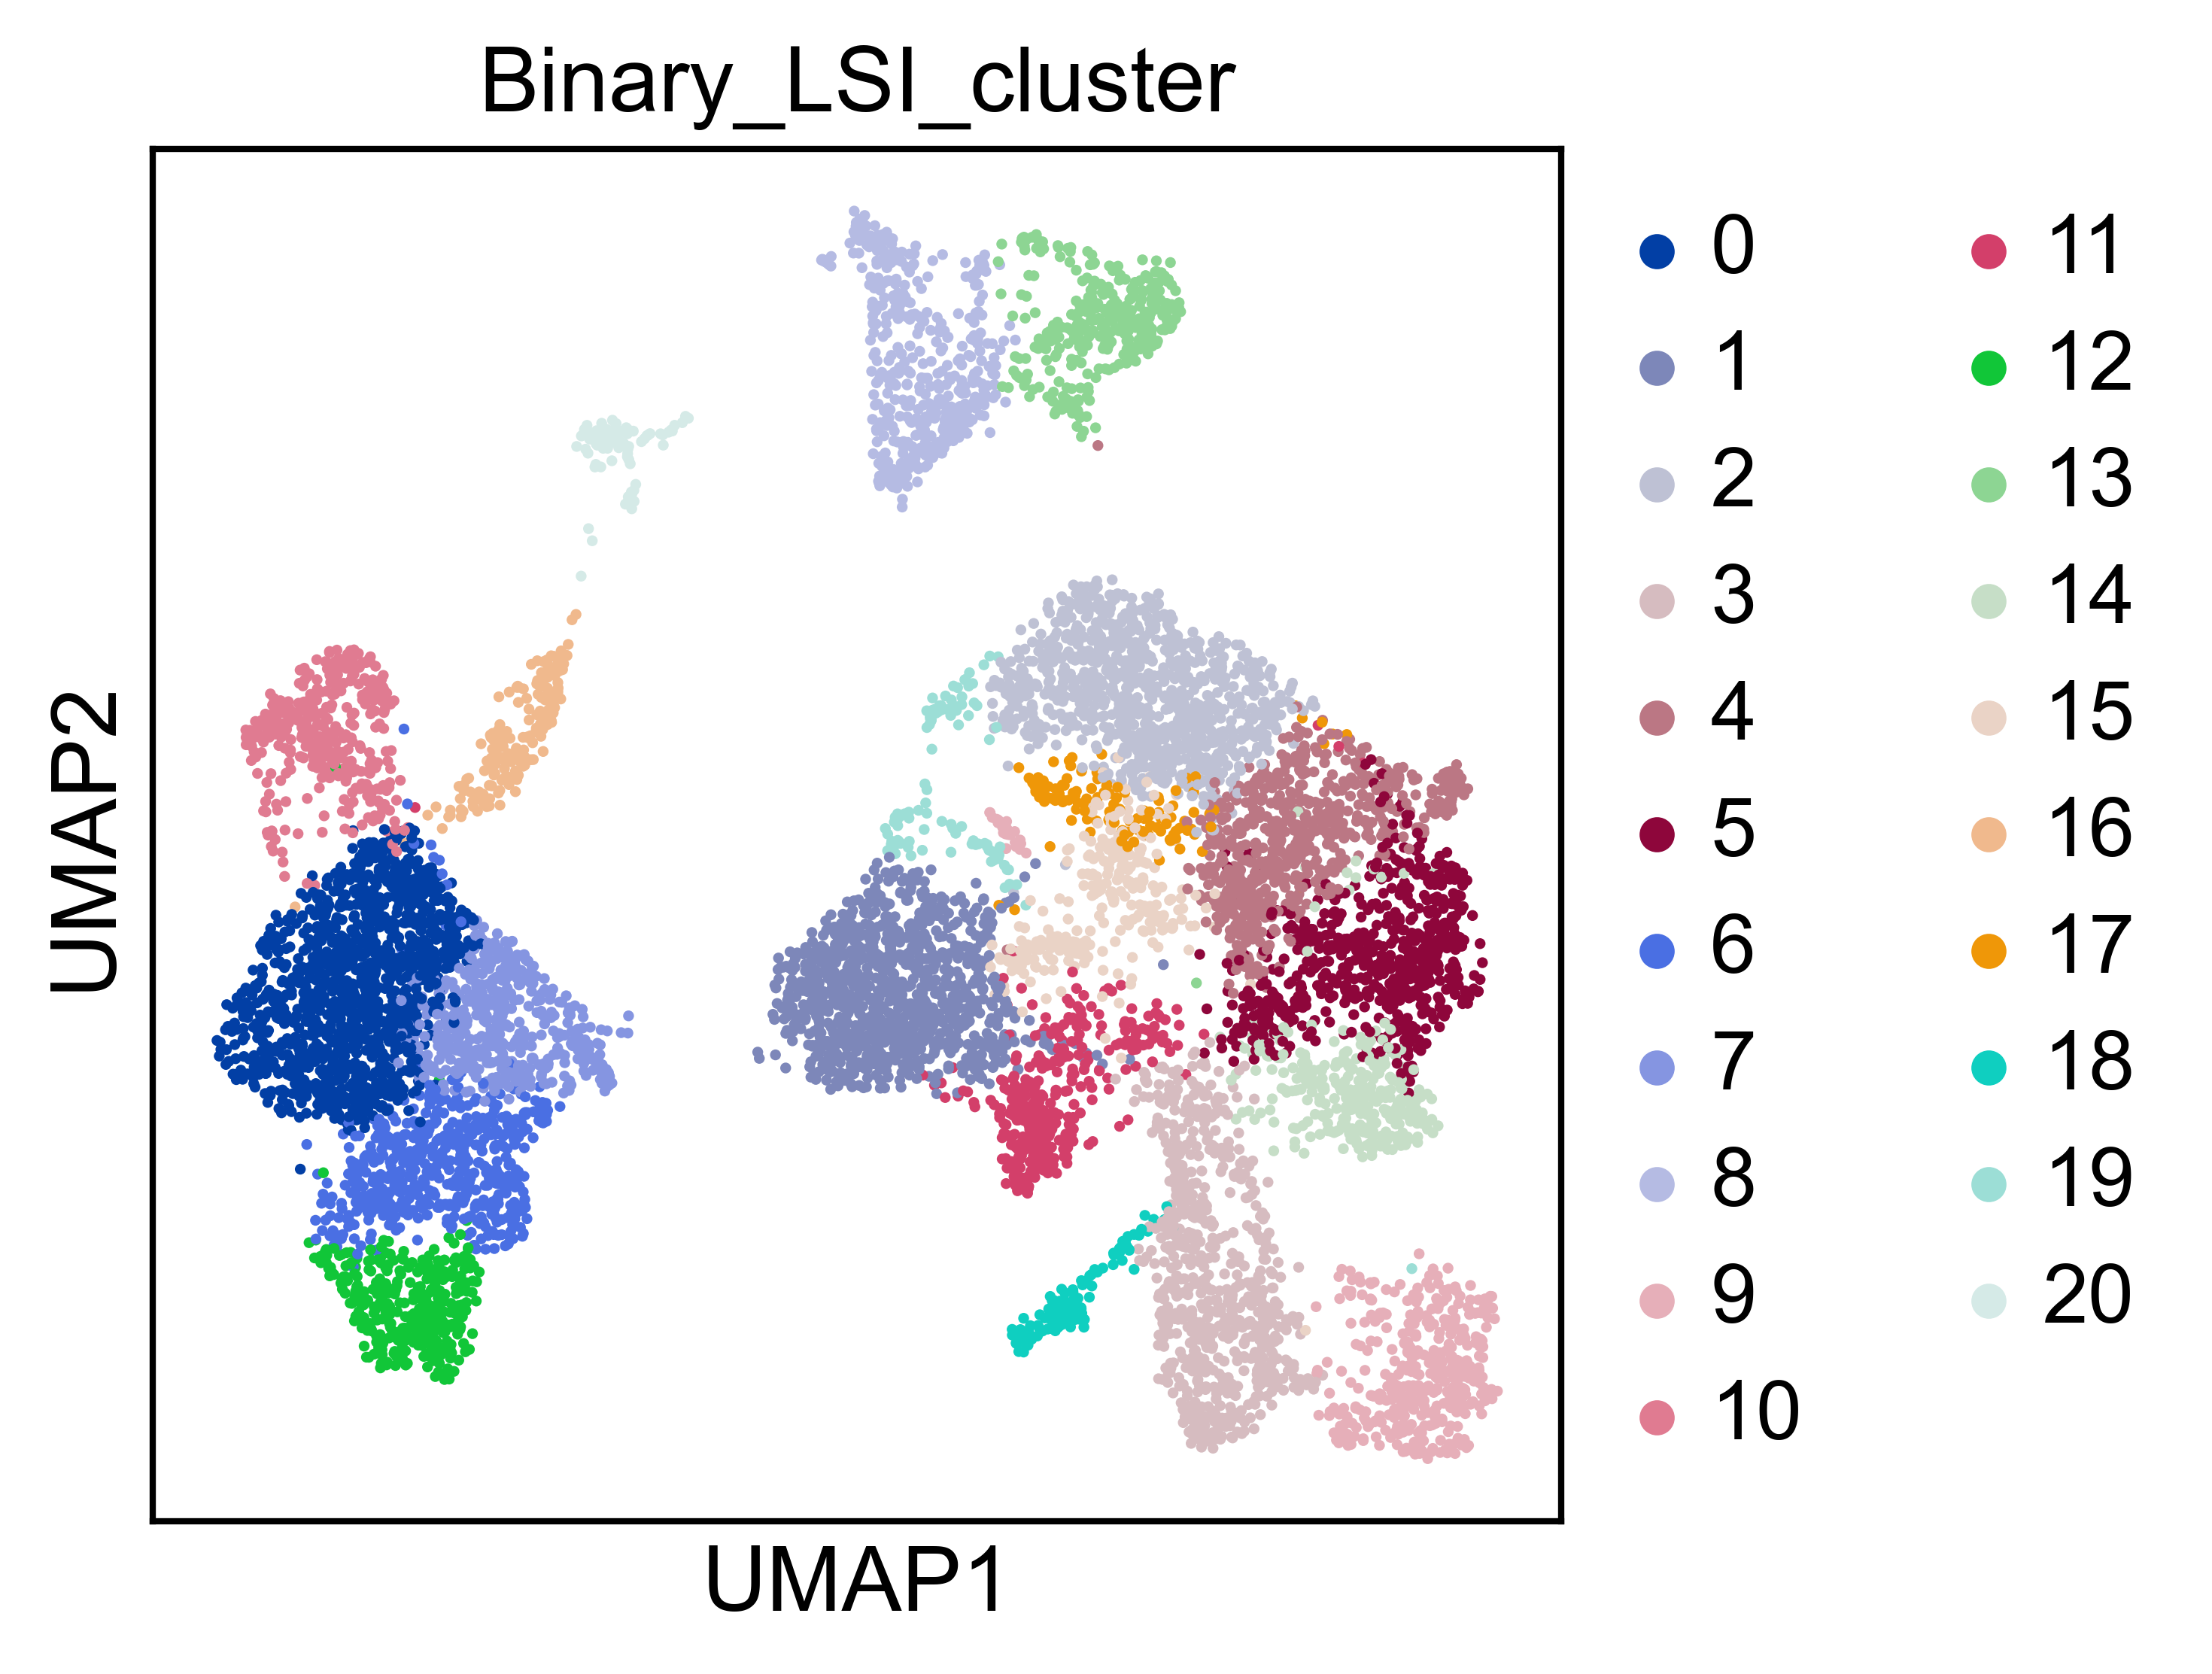

In [ ]:
sc.pl.umap(integ_result, color=['Binary_LSI_cluster'], save='3integ_result_binary_lsi_cluster_3_10.svg')

In [ ]:
integ_result

AnnData object with n_obs × n_vars = 9658 × 132435
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'rna_celltype', 'atac_celltype', 'Binary_LSI_cluster', 'MOFA_Clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg', 'pca', 'pearson_residuals_normalization', 'lsi', 'neighbors', 'tsne', 'umap', 'leiden', 'Binary_LSI_cluster_colors', 'MOFA_Clusters_colors', 'rna_celltype_colors'
    obsm: 'X_pca', 'X_lsi', 'X_tsne', 'X_umap'
    varm: 'PCs', 'LSI'
    obsp: 'distances', 'connectivities'

## PBMC10k MOFA Integration 

MOFA integration is used as a contol. MOFA integration was performed seperately on an GPU enabled High Performance Computing (HPC) grid and imported.

In [ ]:
import mofax as mfx

In [ ]:
# pbmc10k dataset used for MOFA integration

pbmc10k

MuData object with n_obs × n_vars = 9658 × 132435
  obs:	'rna_celltype', 'atac_celltype'
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    rna:	9658 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype', 'rna_celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'
    atac:	9658 x 106086
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts', 'leiden', 'rna_celltype', 'celltype', 'atac_celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'atac', 'atac_celltype_colors', 'celltype_colors', 'files', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'lsi', 'neighbors', 'rank_genes_groups', 'rna_celltype_colors', 'umap'
      obsm:	'X_lsi', 'X_pca', 'X_umap'
      varm:	'LSI'
      layers:	'counts'
      obsp:	'connectivities', 'distances'

In [ ]:
# load mofa pbmc10k mofa model

model = mfx.mofa_model('pbmc10k_mofa.h5mu')

In [ ]:
model

MOFA+ model: pbmc10k mofa.h5mu
Samples (cells): 9658
Features: 22742
Groups: group1 (9658)
Views: atac (19716), rna (3026)
Factors: 10
Expectations: W, Z

In [ ]:
w = model.get_weights()
 # Set the weights of features that were not used to zero
pbmc10k.varm["LFs"] = np.zeros(shape=(pbmc10k.n_vars, w.shape[1]))
pbmc10k.varm["LFs"][pbmc10k.var["highly_variable"].astype(bool)] = w

model.close()

In [ ]:
mu.pp.intersect_obs(pbmc10k)

In [ ]:
pbmc10k.obsm['X_mofa'] = model.get_factors()

In [ ]:
sc.pp.neighbors(pbmc10k, use_rep="X_mofa")
sc.tl.umap(pbmc10k)

/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


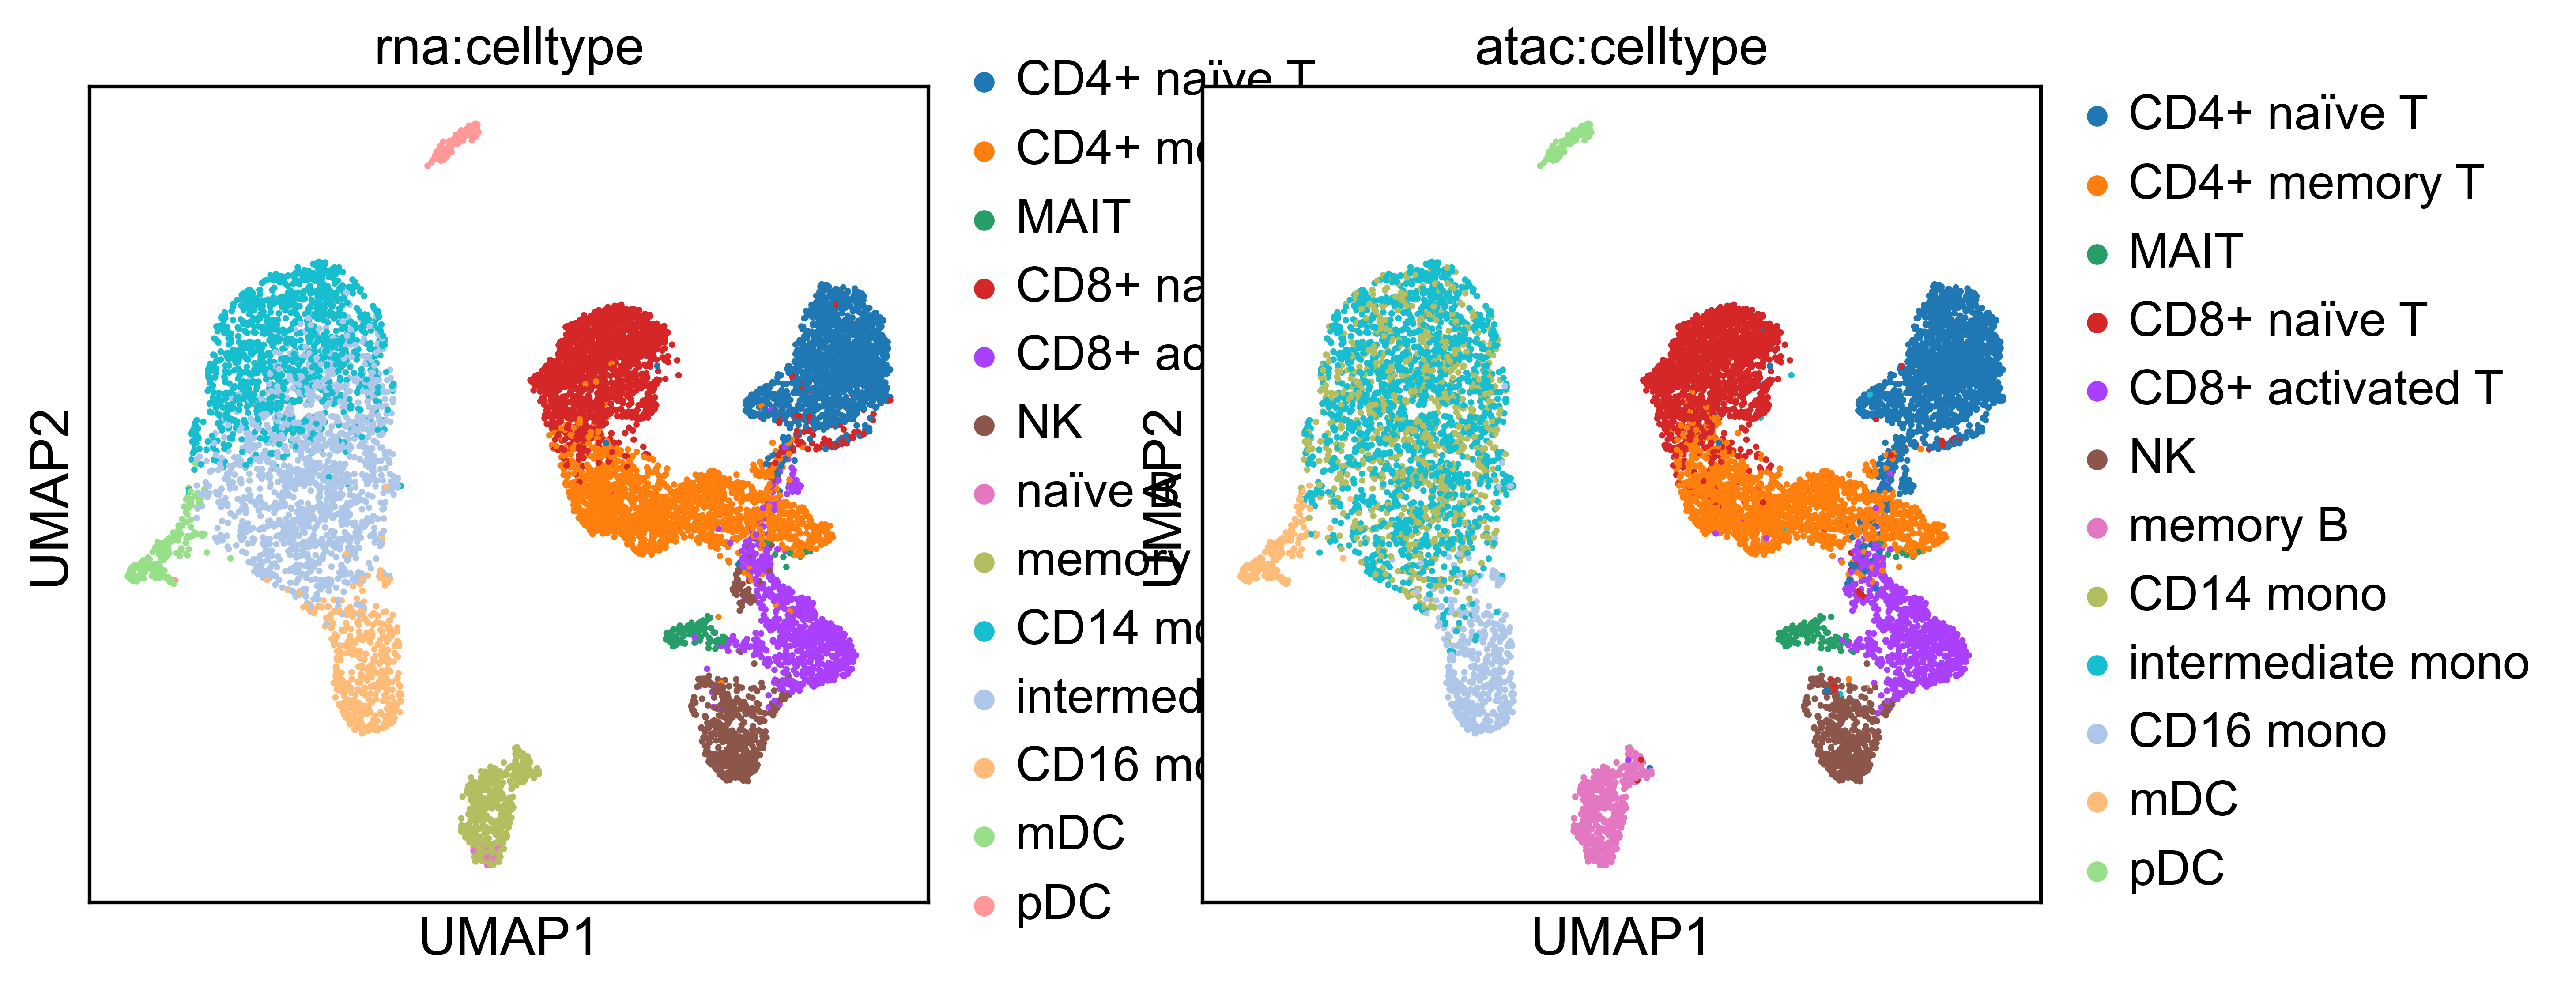

In [ ]:
sc.pl.umap(pbmc10k, color=["rna:celltype", "atac:celltype"])

In [ ]:
sc.tl.leiden(pbmc10k, key_added='MOFA_Clusters', resolution=0.9)

In [ ]:
pbmc10k['rna'].obs['MOFA_Clusters'] = pbmc10k.obs['MOFA_Clusters'].astype('category')

/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


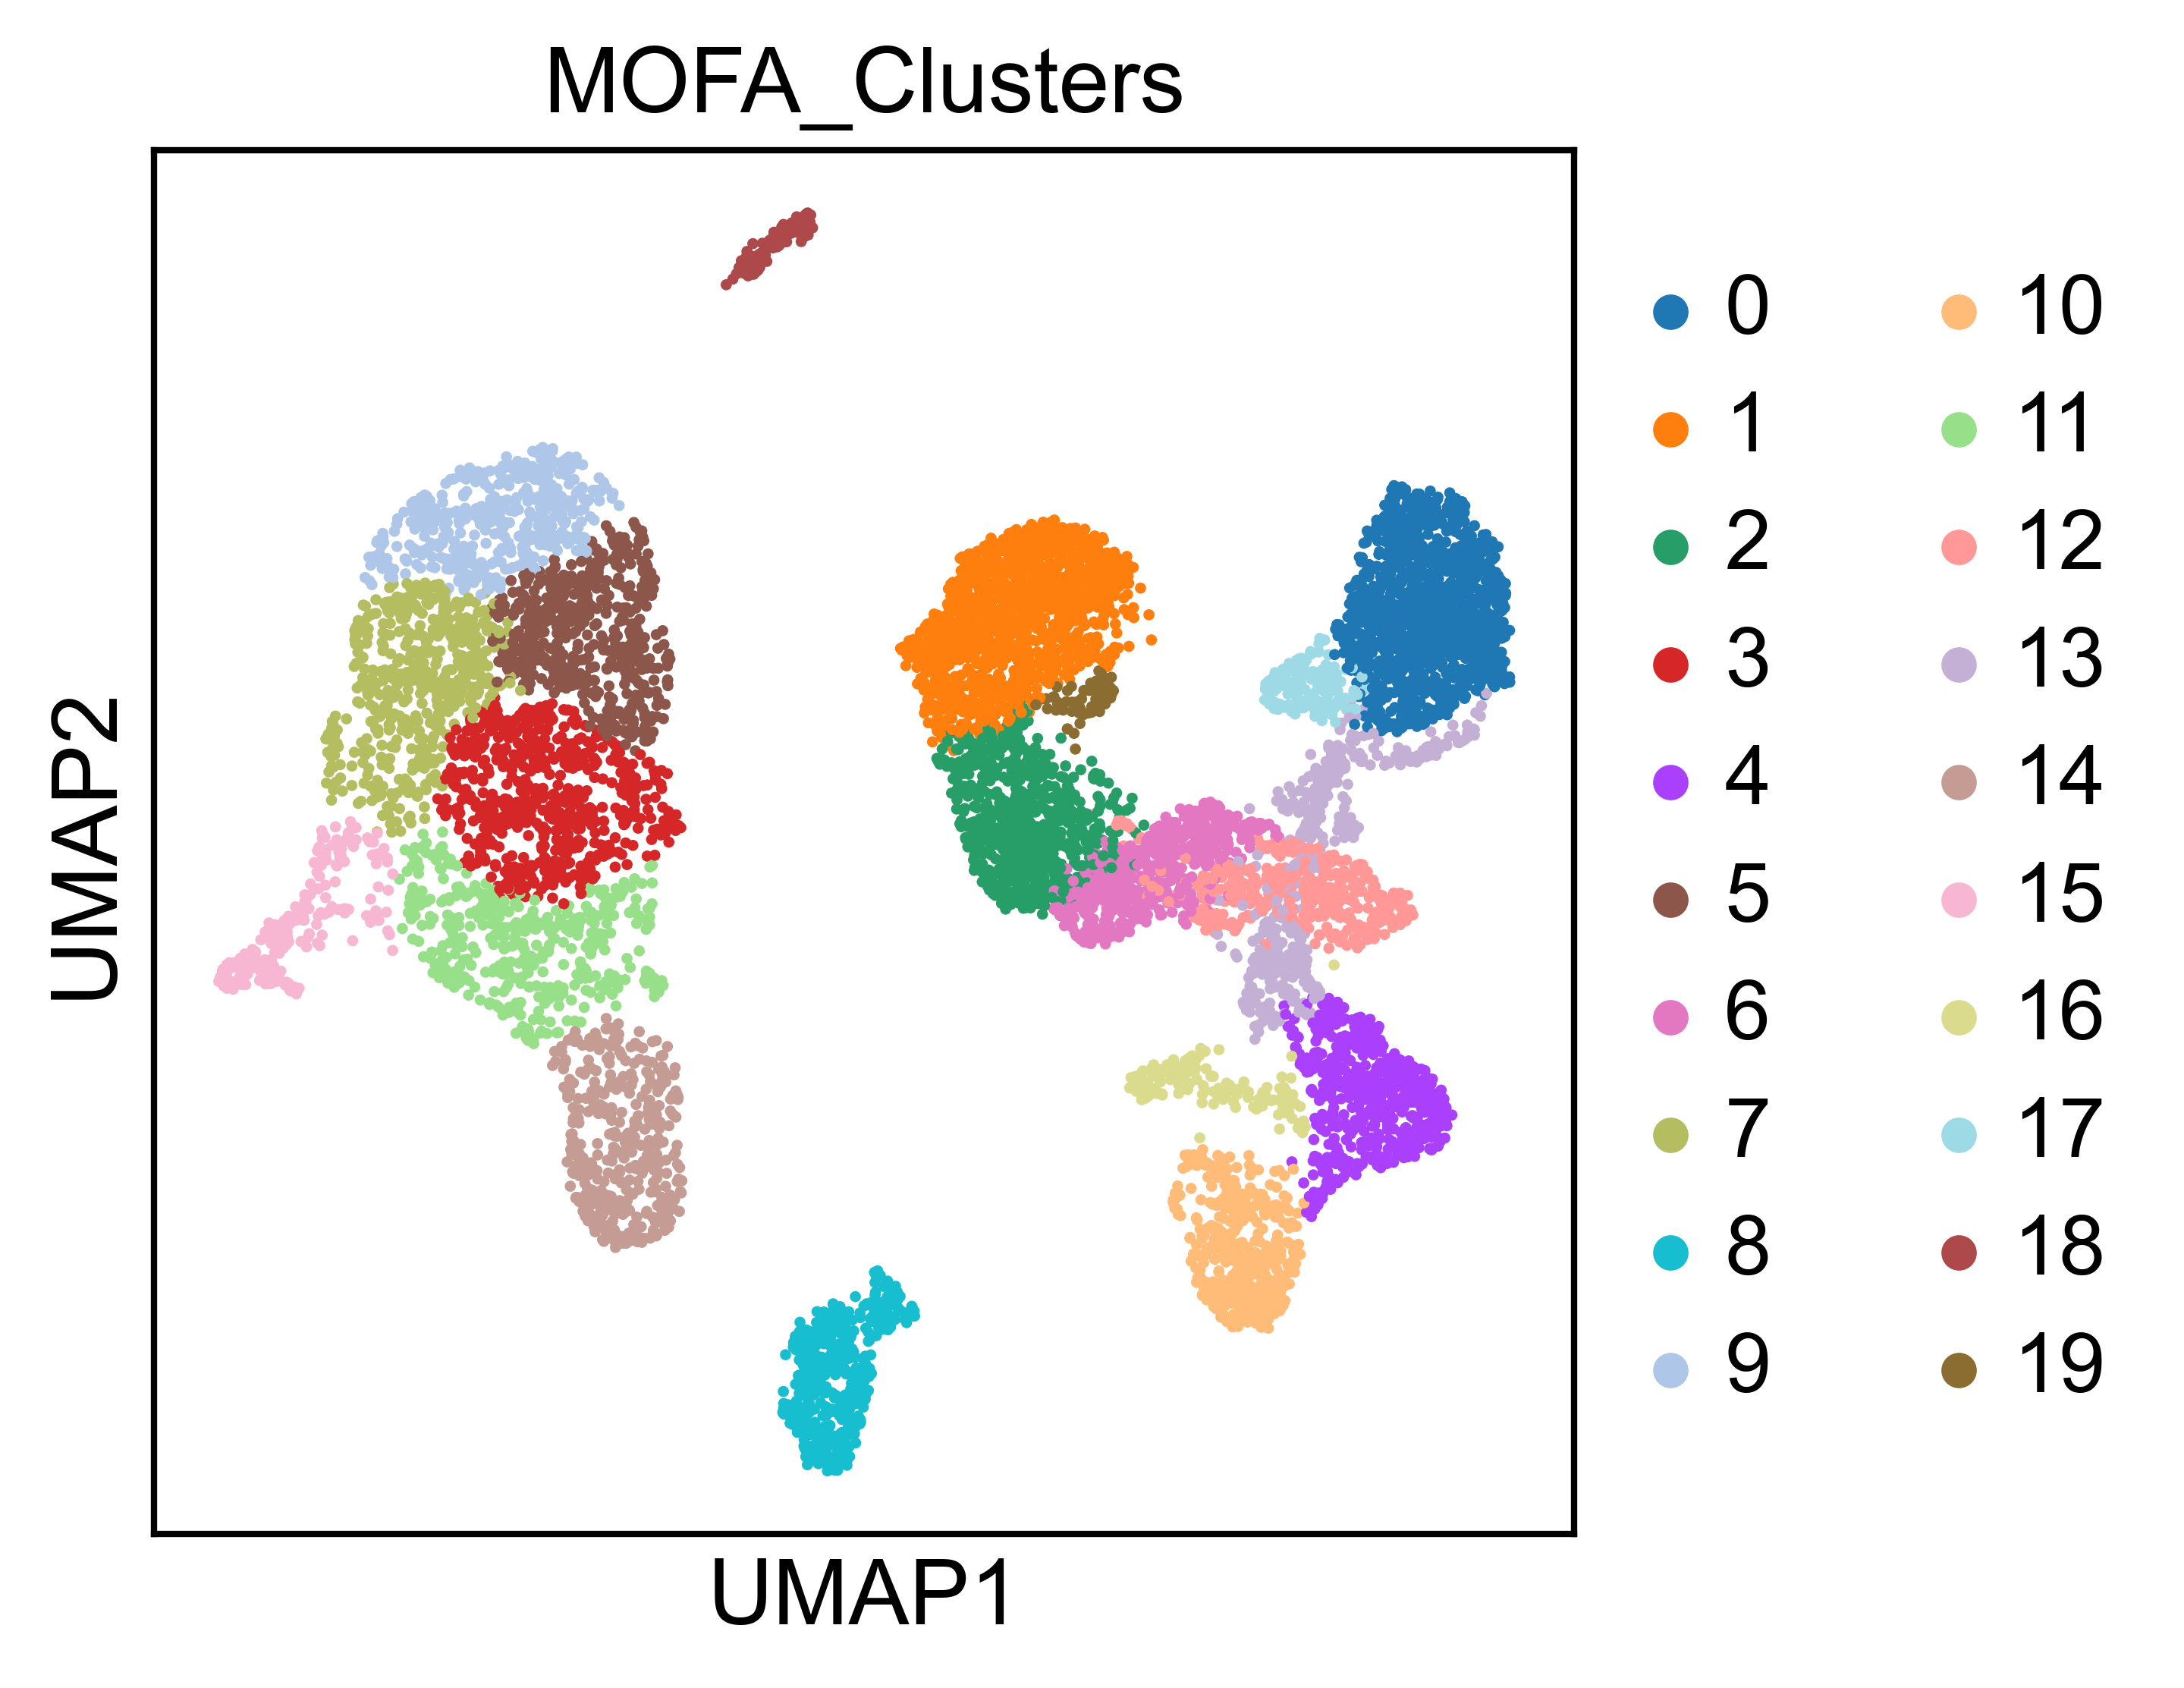

In [ ]:
sc.pl.umap(pbmc10k, color="MOFA_Clusters")

In [ ]:
# rand index between MOFA clusters and Binary LSI clusters

adjusted_rand_score(integ_result.obs['MOFA_Clusters'], integ_result.obs['Binary_LSI_cluster'])


0.5377235092711067

/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/Caskroom/miniconda/base/envs/muon_pysam/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


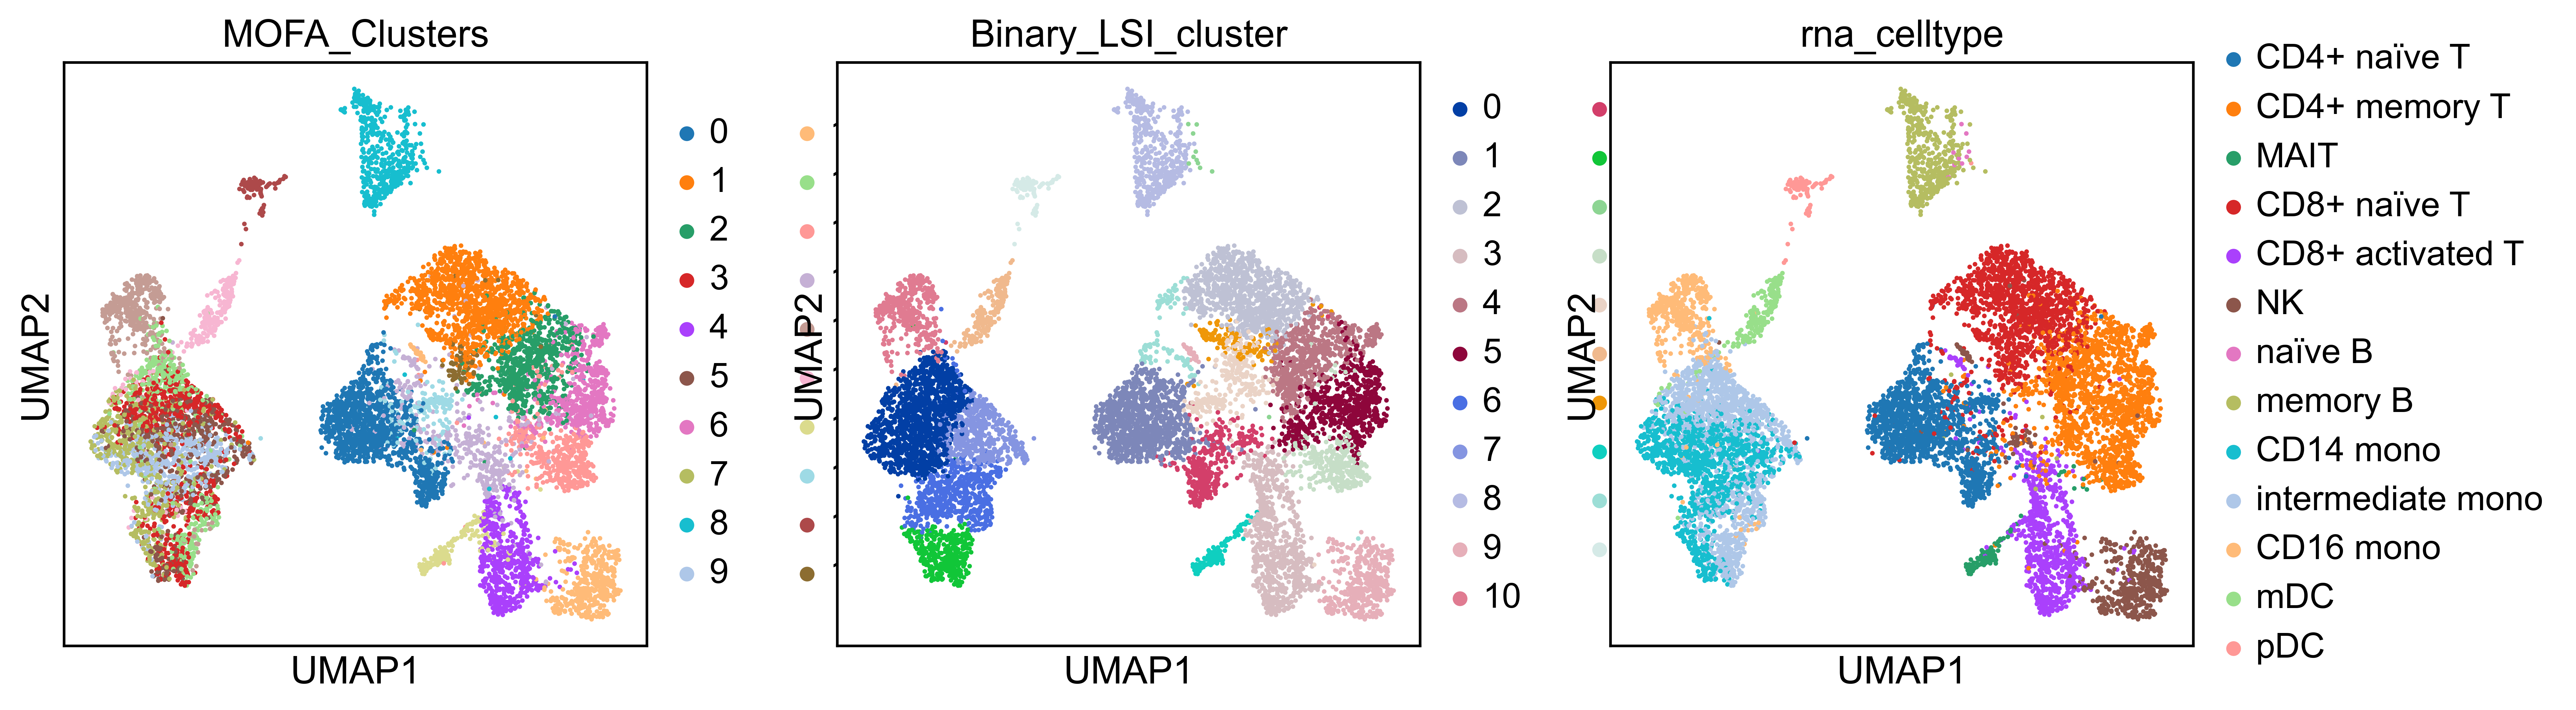

In [ ]:
sc.pl.umap(integ_result, color=['MOFA_Clusters', 'Binary_LSI_cluster', 'rna_celltype'], save='integ_result_MOFA_Clusters2.svg')

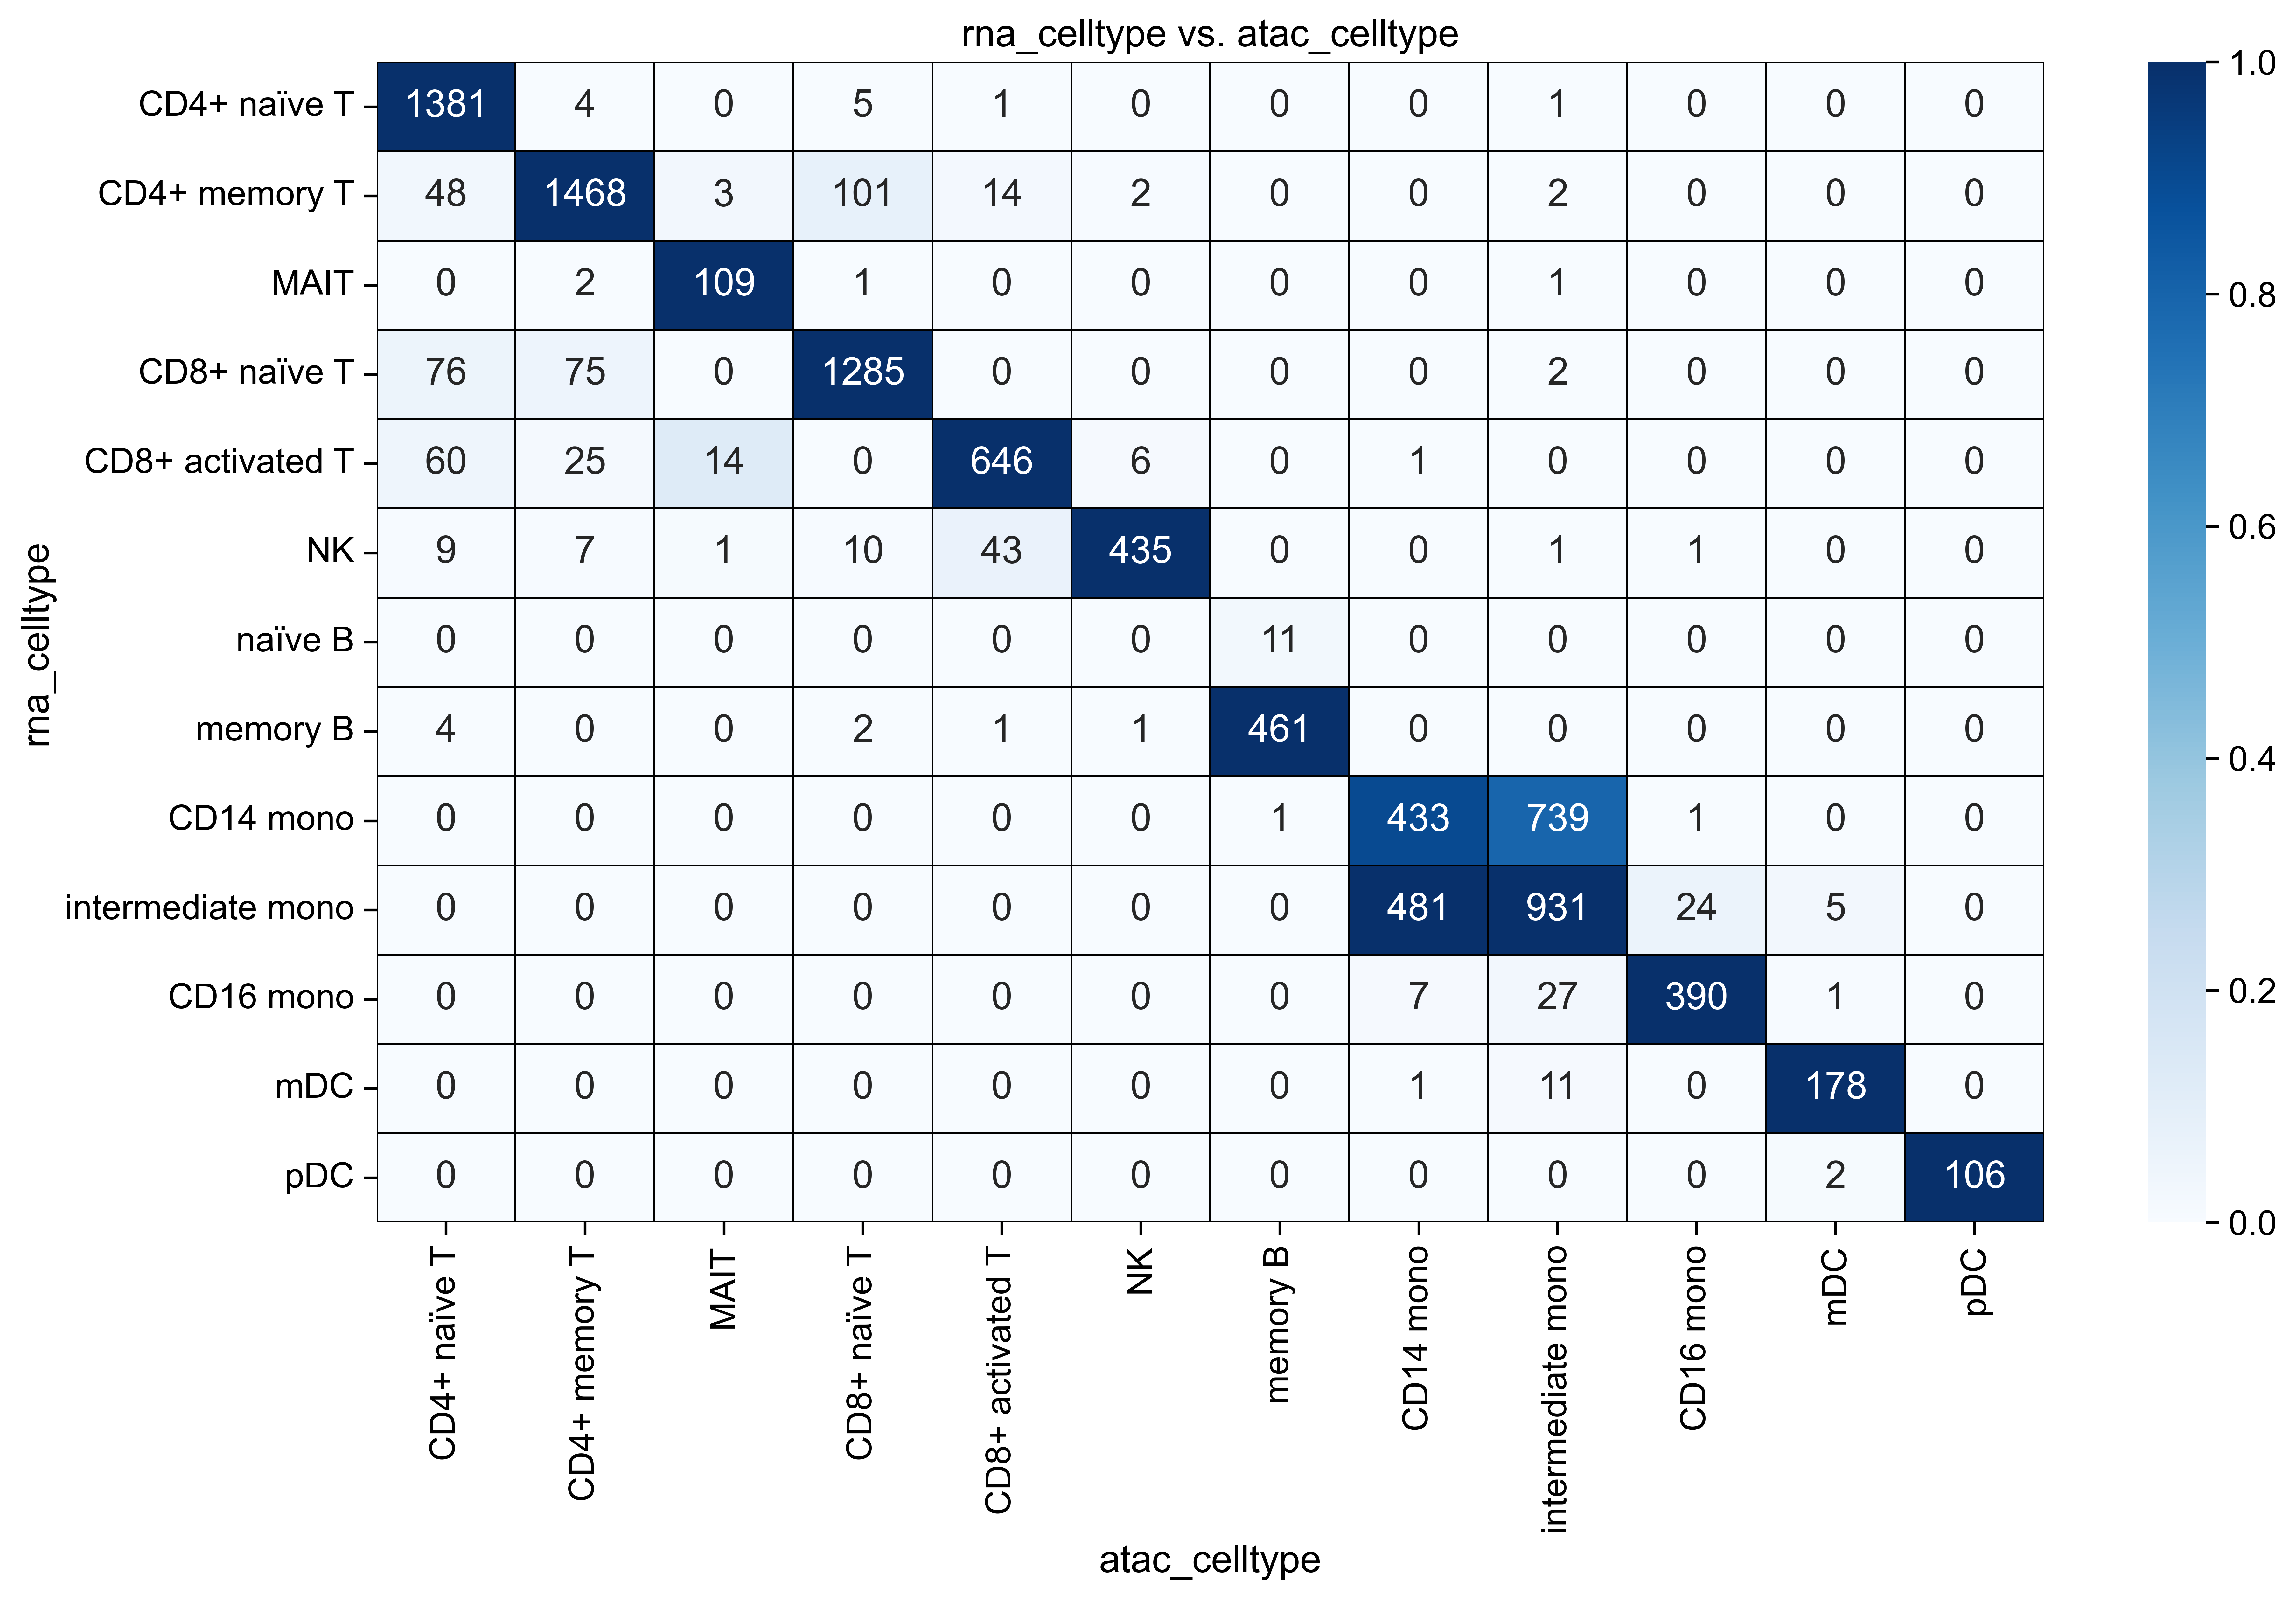

In [ ]:
heatmap_fig_pbmc10k = create_annotated_heatmap(pbmc10k.obs, 'rna_celltype', 'atac_celltype')